<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Packages-+-Data" data-toc-modified-id="Import-Packages-+-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Packages + Data</a></span></li><li><span><a href="#Explore-+-Clean-Data" data-toc-modified-id="Explore-+-Clean-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Explore + Clean Data</a></span><ul class="toc-item"><li><span><a href="#Check-For-Null-Values" data-toc-modified-id="Check-For-Null-Values-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Check For Null Values</a></span></li><li><span><a href="#Check-For-Duplicates" data-toc-modified-id="Check-For-Duplicates-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Check For Duplicates</a></span></li><li><span><a href="#Remove-Outliers" data-toc-modified-id="Remove-Outliers-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Remove Outliers</a></span></li></ul></li></ul></div>

# Import Packages + Data

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import data & convert to df
data = pd.read_excel('Data/Online_Retail.xlsx')
df = pd.DataFrame(data)

# Preview
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


We can see here there are multiple items and quantities purchased on each invoice. I will create another column that shows total spent on each item, so Quantity * UnitPrice. That way we can group by invoice number, customer, etc. and see the total they spent per invoice and item.

We're also going to be adding Recency, Frequency and Monetary columns so we can conduct an RMF analysis and segment customers that way as well. 

Let's take a look at some of the basics before we hop into it. 

# Explore + Clean Data

In [3]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**InvoiceNo** is currently an object. I'm going to change that to an integer so we'll be able to group by invoice number. 

**StockCode** can stay an object, I'm guessing it's a string. 

It's great that **InvoiceDate** is already in datetime format, because we can peak at some time series in the EDA to see if we can collect any further insights. 

## Check For Null Values

In [4]:
# Check for missing values

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

It looks like we have a good amount of Null values for **CustomerID** and **Description**. Let's see how much of the total this accounts for.

In [5]:
# Description
print('Description Percent Null Values:')
print(f"{((df.Description.isnull().sum())/len(df.Description)*100).round(4)} % \n")

# CustomerID
print('CustomerID Percent Null Values:')
print(f"{((df.CustomerID.isnull().sum())/len(df.CustomerID)*100).round(4)} % \n")

print('==============================')

Description Percent Null Values:
0.2683 % 

CustomerID Percent Null Values:
24.9267 % 



The number of missing values for the **Description** column is small, however for the **CustomerID** column it is large at almost 25%. I'm curious how many customers there were. Let's take a look at the number of unique values.

In [6]:
# Unique CustomerIDs

print(f'No. of unique CustomerIDs: \n{len(df.CustomerID.value_counts())}')

No. of unique CustomerIDs: 
4372


Since we still have data from over 4,300 customers, and we don't have any way of identifying the customers with the Null **CustomerID** field, it only makes sense to remove them. And since the number of Null **Description** fields are low, we will remove those as well. 

In [7]:
# Drop rows w/null fields
df = df.dropna()

In [8]:
len(df)

406829

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Check For Duplicates

In [10]:
#df[df.duplicated()]
df[df.InvoiceNo == 536412].duplicated()

541    False
542    False
543    False
544    False
545    False
       ...  
617     True
618     True
619    False
620     True
621    False
Length: 81, dtype: bool

In [11]:
df.iloc[617:622]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
617,536412,22900,SET 2 TEA TOWELS I LOVE LONDON,2,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
618,536412,21706,FOLDING UMBRELLA RED/WHITE POLKADOT,1,2010-12-01 11:49:00,4.95,17920.0,United Kingdom
619,536412,22988,SOLDIERS EGG CUP,6,2010-12-01 11:49:00,1.25,17920.0,United Kingdom
620,536412,85184C,S/4 VALENTINE DECOUPAGE HEART BOX,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
621,536412,20750,RED RETROSPOT MINI CASES,1,2010-12-01 11:49:00,7.95,17920.0,United Kingdom


None of these seem to be duplicates, so we're going to leave these here. 

In [12]:
# Summary statistics

df.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69
std,248.69,69.32,1713.60
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13953.00
50%,5.00,1.95,15152.00
75%,12.00,3.75,16791.00
max,80995.00,38970.00,18287.00


## Remove Outliers

It looks like there are some major outliers in our dataset. Let's remove them. 

In [13]:
# Percentiles for Quantity

# Define percentiles
percentiles = [0,2.5,97.5,100]

# Print them out
for i in percentiles:
    q = i/100
    print("{} percentile Quantity: {}".format(q, df.Quantity.quantile(q=q)))
    
# Percentiles for UnitPrice

# Print them out
for i in percentiles:
    q = i/100
    print("{} percentile UnitPrice: {}".format(q, df.UnitPrice.quantile(q=q)))

0.0 percentile Quantity: -80995.0
0.025 percentile Quantity: 1.0
0.975 percentile Quantity: 72.0
1.0 percentile Quantity: 80995.0
0.0 percentile UnitPrice: 0.0
0.025 percentile UnitPrice: 0.39
0.975 percentile UnitPrice: 11.95
1.0 percentile UnitPrice: 38970.0


I'm going to remove what may be returns or negative **Quantity** values as the lower 1% is -2.0 and the lower 2.5% was 1.0. We also removed all of the negative UnitPrice values when we removed the Null **CustomerID** values. 

We're also going to set the **UnitPrice** lower limit to be any value greater than 0.0 as this means it has any price. The minimum value being 0.001. 

In [14]:
# Remove extreme outliers in the lower and upper 1%

# Get original length to see percent removed
orig_tot = len(df)

# Subset to remove extreme outliers
# Quantity
df = df[(df.Quantity > 0.0) & (df.Quantity <= 120.0)] 
# UnitPrice lot
df = df[(df.UnitPrice > 0.0) & (df.UnitPrice <= 15.0)]

# Calculate percent removed
print('Percent removed:', (orig_tot -len(df))/orig_tot)

Percent removed: 0.04014954686121196


We saw how removing the rows with Null **CustomerIDs** also removed the negative **UnitPrices**, I'm wondering if it would be best to remove the rows with negative Quantity value as well. We can see here with the 1% being -2.0, the 2% being -1.0 and the 2.5% being 1.0. 

I will keep it standard for now with percentiles, however it ma

It seems returns are extremely rare, which we can see with the **Quantity** 0.01 percentile being -2.0. I'm wondering if returns should be removed alltogether since they are rare, or if there are certain segments of customers who are more prone to returns.

In [15]:
# Pairplot
#sns.pairplot(df);

We can see there are negative values for Quantity. These most likely represent returns. 

It seems too we have some major outliers that make the rest of the data look pretty squished together, so we can take a closer look at those and clean them up if necessary. 

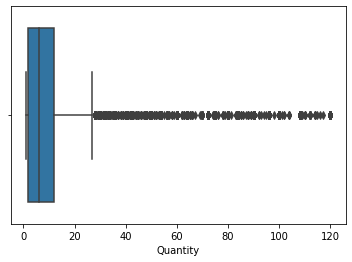

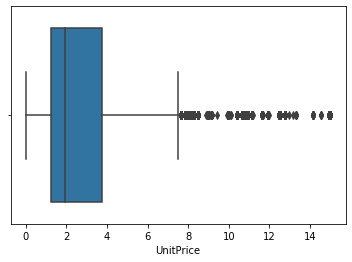

In [16]:
sns.boxplot(df.Quantity)
plt.show()

sns.boxplot(df.UnitPrice)
plt.show()

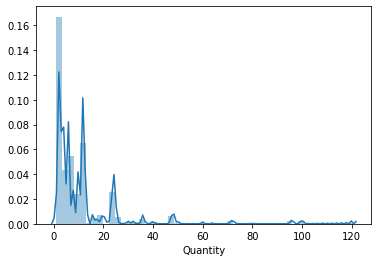

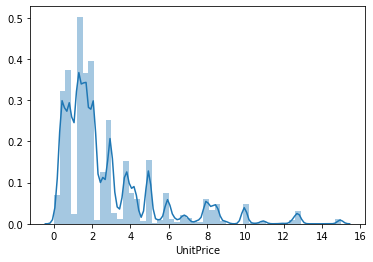

In [17]:
sns.distplot(df.Quantity)
plt.show()
sns.distplot(df.UnitPrice)
plt.show()

It seems that removing the Null **CustomerID** data also removed all of the negative **UnitPrice** values. 

We can see visually there are some major outliers. With this data set it's easy to visually see the outliers, so I could remove them that way, however I'm going to remove them by removing the upper and lower percentiles. 